In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as P
import tensorflow.keras as  keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import normalize
import scipy.stats as ss
import pickle
import math
import os
import shap
from sklearn.metrics import *

from time import time
#from get_data import *

In [5]:
def split_data(df, look_back=12, ratio=0.8, predict_n=5, Y_column=0):
    """
    Split the data into training and test sets
    Keras expects the input tensor to have a shape of (nb_samples, timesteps, features).
    :param df: Pandas dataframe with the data.
    :param look_back: Number of weeks to look back before predicting
    :param ratio: fraction of total samples to use for training
    :param predict_n: number of weeks to predict
    :param Y_column: Column to predict
    :return:
    """
    df = np.nan_to_num(df.values).astype("float64")
    # n_ts is the number of training samples also number of training sets
    # since windows have an overlap of n-1
    n_ts = df.shape[0] - look_back - predict_n + 1
    # data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    for i in range(n_ts):  # - predict_):
        #         print(i, df[i: look_back+i+predict_n,0])
        data[i, :, :] = df[i: look_back + i + predict_n, :]
    # train_size = int(n_ts * ratio)
    train_size = int(df.shape[0] * ratio) - look_back
    print(train_size)

    # We are predicting only column 0
    X_train = data[:train_size, :look_back, :]
    Y_train = data[:train_size, look_back:, Y_column]
    X_test = data[train_size:, :look_back, :]
    Y_test = data[train_size:, look_back:, Y_column]

    return X_train, Y_train, X_test, Y_test


def normalize_data(df, log_transform=False):
    """
    Normalize features in the example table
    :param df:
    :return:
    """     
    df.fillna(0, inplace=True)
    norm = normalize(df, norm='max', axis=0)
    if log_transform==True:
        norm = np.log(norm)
    df_norm = pd.DataFrame(norm, columns=df.columns)

    return df_norm, df.max(axis=0)

In [6]:
def build_model(hidden, features, predict_n, look_back=10, batch_size=1):
    """
    Builds and returns the LSTM model with the parameters given
    :param hidden: number of hidden nodes
    :param features: number of variables in the example table
    :param look_back: Number of time-steps to look back before predicting
    :param batch_size: batch size for batch training
    :return:
    """
    inp = keras.Input(
        shape=(look_back, features),
        # batch_shape=(batch_size, look_back, features)
    )
    x = Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
         activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    x = Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        #return_sequences=True,
         activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    out = Dense(
        predict_n,
        activation="relu",
        kernel_initializer="random_uniform",
        bias_initializer="zeros",
    )(x)
    model = keras.Model(inp, out)

    start = time()
    model.compile(loss="msle", optimizer="adam", metrics=["accuracy", "mape", "mse"])
    print("Compilation Time : ", time() - start)
    plot_model(model, to_file="LSTM_model.png")
    print(model.summary())
    return model


def train(model, X_train, Y_train, batch_size=1, epochs=10, geocode=None, overwrite=True):
    TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        # embeddings_freq=10
    )

    hist = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.15,
        verbose=1,
        callbacks=[TB_callback, EarlyStopping(patience=15)]
    )
    with open("history_{}.pkl".format(geocode), "wb") as f:
        pickle.dump(hist.history, f)
    model.save_weights("trained_{}_model.h5".format(geocode), overwrite=overwrite)
    return hist


def plot_training_history(hist):
    """
    Plot the Loss series from training the model
    :param hist: Training history object returned by "model.fit()"
    """
    df_vloss = pd.DataFrame(hist.history["val_loss"], columns=["val_loss"])
    df_loss = pd.DataFrame(hist.history["loss"], columns=["loss"])
    df_mape = pd.DataFrame(
        hist.history["mean_absolute_percentage_error"], columns=["mape"]
    )
    ax = df_vloss.plot(logy=True)
    df_loss.plot(ax=ax, grid=True, logy=True)
    # df_mape.plot(ax=ax, grid=True, logy=True);
    # P.savefig("{}/LSTM_training_history.png".format(FIG_PATH))


def plot_predicted_vs_data(predicted, Ydata, indice, label, pred_window, factor, split_point=None, uncertainty=False):
    """
    Plot the model's predictions against data
    :param predicted: model predictions
    :param Ydata: observed data
    :param indice:
    :param label: Name of the locality of the predictions
    :param pred_window:
    :param factor: Normalizing factor for the target variable
    """

    P.clf()
    if len(predicted.shape) == 2:
        df_predicted = pd.DataFrame(predicted)
        df_predicted25 = None
    else:
        df_predicted = pd.DataFrame(np.percentile(predicted, 50, axis=2))
        df_predicted25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
        df_predicted975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))
        uncertainty = True
    ymax = max(predicted.max() * factor, Ydata.max() * factor)
    P.vlines(indice[split_point], 0, ymax, "g", "dashdot", lw=2)
    P.text(indice[split_point + 2], 0.6 * ymax, "Out of sample Predictions")
    # plot only the last (furthest) prediction point
    P.plot(indice[len(indice)-Ydata.shape[0]:], Ydata[:, -1] * factor, 'k-', alpha=0.7, label='data')
    P.plot(indice[len(indice)-Ydata.shape[0]:], df_predicted.iloc[:,-1] * factor, 'r-', alpha=0.5, label='median')
    if uncertainty:
        P.fill_between(indice[len(indice)-Ydata.shape[0]:], df_predicted25[df_predicted25.columns[-1]] * factor,
                       df_predicted975[df_predicted975.columns[-1]] * factor,
                       color='b', alpha=0.3)

    # plot all predicted points
    # P.plot(indice[pred_window:], pd.DataFrame(Ydata)[7] * factor, 'k-')
    # for n in range(df_predicted.shape[1] - pred_window):
    #     P.plot(
    #         indice[n: n + pred_window],
    #         pd.DataFrame(Ydata.T)[n] * factor,
    #         "k-",
    #         alpha=0.7,
    #     )
    #     P.plot(indice[n: n + pred_window], df_predicted[n] * factor, "r-")
    #     try:
    #         P.vlines(
    #             indice[n + pred_window],
    #             0,
    #             df_predicted[n].values[-1] * factor,
    #             "b",
    #             alpha=0.2,
    #         )
    #     except IndexError as e:
    #         print(indice.shape, n, df_predicted.shape)
    tag = '_unc' if uncertainty else ''
    P.grid()
    P.title("Predictions for {}".format(label))
    P.xlabel("time")
    P.ylabel("incidence")
    P.xticks(rotation=70)
    P.legend(["data", "predicted"])
    P.savefig(
        "lstm_{}{}.png".format(label, tag),
        bbox_inches="tight",
        dpi=300,
    )
    P.show()


def loss_and_metrics(model, Xtest, Ytest):
    print(model.evaluate(Xtest, Ytest, batch_size=1))


def evaluate(model, Xdata, Ydata, label, uncertainty=False):
    loss_and_metrics(model, Xdata, Ydata)
    metrics = model.evaluate(Xdata, Ydata, batch_size=1)
    # with open('metrics_{}.pkl'.format(label), 'wb') as f:
    #     pickle.dump(metrics, f)
    if uncertainty:
        predicted = np.stack([model.predict(Xdata, batch_size=1, verbose=1) for i in range(100)], axis=2)
    else:
        predicted = model.predict(Xdata, batch_size=1, verbose=1)
    return predicted, metrics


def calculate_metrics(pred, ytrue, factor):
    metrics = pd.DataFrame(
        index=(
            "mean_absolute_error",
            "explained_variance_score",
            "mean_squared_error",
            "mean_squared_log_error",
            "median_absolute_error",
            "r2_score",
        )
    )
    for col in range(pred.shape[1]):
        y = ytrue[:, col] * factor
        p = pred[:, col] * factor
        l = [
            mean_absolute_error(y, p),
            explained_variance_score(y, p),
            mean_squared_error(y, p),
            mean_squared_log_error(y, p),
            median_absolute_error(y, p),
            r2_score(y, p),
        ]
        metrics[col] = l
    return metrics


def train_evaluate_model(target_name, data, predict_n, look_back, hidden, epochs, ratio=0.75, cluster=True, load=False,
                         uncertainty=True):
    """
    Train the model
    :param city: Name of the city
    :param data: Dataset
    :param predict_n: Number of steps ahead to be predicted
    :param look_back: number of history steps to include in training window
    :param hidden: Number of Hidden layer
    :param epochs: number of training epochs
    :param ratio: ratio of the full dataset to use in training
    :param load: Whether to load a previously saved model
    :return:
    """
        
    target_col = data.columns.get_loc("hosp_GE")
   
    norm_data, max_features = normalize_data(data)
    
    factor = max_features[target_col]

    ##split test and train
    X_train, Y_train, X_test, Y_test = split_data(
        norm_data,
        look_back=look_back,
        ratio=ratio,
        predict_n=predict_n,
        Y_column=target_col,
    )
    # print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

    ## Run model
    model = build_model(
        hidden, X_train.shape[2], predict_n=predict_n, look_back=look_back
    )
    #if load:
        #model.load_model("../saved_models/LSTM/{}/lstm_{}_epochs_{}.h5".format(STATE, city, epochs))
        
    history = train(model, X_train, Y_train, batch_size=1, epochs=epochs, geocode=target_name)
    model.save('lstm_{}_epochs_{}.h5'.format(target_name, epochs))

    predicted_out, metrics_out = evaluate(model, X_test, Y_test, label="out_of_sample_{}".format(target_name), uncertainty=uncertainty
    )
    predicted_in, metrics_in = evaluate(model, X_train, Y_train, label="in_sample_{}".format(target_name), uncertainty=uncertainty
    )
    if uncertainty:
        pout = np.percentile(predicted_out, 50, axis=2)
    else:
        pout = predicted_out
    if ratio < 1:
        metrics = calculate_metrics(pout, Y_test, factor)
        metrics.to_pickle(
            "metrics_lstm_{}_8pw.pkl".format(target_name)
        )

    if ratio < 1:
        predicted = np.concatenate((predicted_in, predicted_out), axis=0)
    else:  # In this case there is no Test set (ratio=1)
        predicted = predicted_in
    with open(
            "predicted_lstm_{}_8pw.pkl".format(target_name), "wb"
    ) as f:
        pickle.dump(predicted, f)

    return predicted, X_train, X_test, Y_test, Y_train, factor


In [7]:
df = pd.read_csv('data_GE.csv')
df.set_index('datum', inplace = True)

df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
df = df.loc['2021-01-01':]
df

,cases_FR,diff_cases_FR,diff_2_cases_FR,cases_GE,diff_cases_GE,diff_2_cases_GE,cases_GR,diff_cases_GR,diff_2_cases_GR,cases_JU,...,test_TI,diff_test_TI,diff_2_test_TI,test_VD,diff_test_VD,diff_2_test_VD,test_VS,diff_test_VS,diff_2_test_VS,vac_all
datum,,,,,,,,,,,,,,,,,,,,,
2021-01-01,68.285714,0.571429,-1.142857,130.571429,2.285714,3.714286,72.857143,-0.285714,-3.000000,29.000000,...,1114.428571,-15.285714,10.571429,2115.714286,-32.000000,129.000000,834.571429,20.142857,18.285714,0.044286
2021-01-02,72.000000,3.714286,3.142857,134.714286,4.142857,1.857143,75.285714,2.428571,2.714286,30.000000,...,1124.857143,10.428571,25.714286,2085.714286,-30.000000,2.000000,864.285714,29.714286,9.571429,0.052857
2021-01-03,75.000000,3.000000,-0.714286,134.142857,-0.571429,-4.714286,75.285714,0.000000,-2.428571,32.285714,...,1133.428571,8.571429,-1.857143,2097.142857,11.428571,41.428571,882.142857,17.857143,-11.857143,0.061429
2021-01-04,83.000000,8.000000,5.000000,127.857143,-6.285714,-5.714286,75.571429,0.285714,0.285714,36.142857,...,1179.428571,46.000000,37.428571,2152.285714,55.142857,43.714286,885.000000,2.857143,-15.000000,0.074286
2021-01-05,89.000000,6.000000,-2.000000,124.857143,-3.000000,3.285714,75.428571,-0.142857,-0.428571,37.142857,...,1194.428571,15.000000,-31.000000,2173.285714,21.000000,-34.142857,918.714286,33.714286,30.857143,0.095714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09,1352.000000,-4.571429,-70.428571,2443.428571,-1.142857,-119.857143,1013.285714,-13.714286,-48.571429,382.000000,...,3794.285714,61.000000,-192.714286,8843.142857,111.857143,-507.428571,4036.571429,53.571429,-170.285714,162.535714
2022-01-10,1363.000000,11.000000,15.571429,2520.571429,77.142857,78.285714,975.285714,-38.000000,-24.285714,348.571429,...,3848.000000,53.714286,-7.285714,9018.714286,175.571429,63.714286,4030.142857,-6.428571,-60.000000,163.337143
2022-01-11,1334.857143,-28.142857,-39.142857,2515.857143,-4.714286,-81.857143,927.857143,-47.428571,-9.428571,319.000000,...,3851.714286,3.714286,-50.000000,9028.142857,9.428571,-166.142857,3984.571429,-45.571429,-39.142857,164.125714


In [9]:
df_n = pd.DataFrame()

for i in df.columns: 
    
    if i.endswith('GE'):
        
        df_n[i] = df[i]

#df_n['vac_all'] = df['vac_all']
df_n

,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE,test_GE,diff_test_GE,diff_2_test_GE
datum,,,,,,,,,
2021-01-01,130.571429,2.285714,3.714286,4.142857,0.142857,0.428571,1515.428571,-28.142857,199.285714
2021-01-02,134.714286,4.142857,1.857143,4.571429,0.428571,0.285714,1480.714286,-34.714286,-6.571429
2021-01-03,134.142857,-0.571429,-4.714286,4.714286,0.142857,-0.285714,1446.285714,-34.428571,0.285714
2021-01-04,127.857143,-6.285714,-5.714286,4.571429,-0.142857,-0.285714,1426.285714,-20.000000,14.428571
2021-01-05,124.857143,-3.000000,3.285714,4.285714,-0.285714,-0.142857,1441.428571,15.142857,35.142857
...,...,...,...,...,...,...,...,...,...
2022-01-09,2443.428571,-1.142857,-119.857143,19.285714,-1.714286,0.285714,6920.285714,130.428571,-189.428571
2022-01-10,2520.571429,77.142857,78.285714,17.142857,-2.142857,-0.428571,7029.142857,108.857143,-21.571429
2022-01-11,2515.857143,-4.714286,-81.857143,15.000000,-2.142857,0.000000,7106.714286,77.571429,-31.285714


In [23]:
%%time
predicted, X_train, X_test, Y_test, Y_train, factor = train_evaluate_model(target_name = 'hosp_GE', data = df_n[['hosp_GE', 'diff_hosp_GE', 'diff_2_hosp_GE', 'cases_GE', 'diff_cases_GE']],
predict_n = 14, look_back = 14, hidden = 10, epochs = 100, ratio=0.75, cluster=True, load=False,
                         uncertainty= True)

269



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Compilation Time :  0.005809307098388672
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14, 5)]           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 10)                1280      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                154       
Total params: 1,434
Trainable params: 1,434
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100


2022-01-21 18:09:11.980421: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-21 18:09:11.980459: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-21 18:09:11.980523: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-01-21 18:09:11.980541: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


  2/228 [..............................] - ETA: 24s - loss: 0.0844 - accuracy: 0.0000e+00 - mape: 98.7464 - mse: 0.1157 

2022-01-21 18:09:14.493925: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-21 18:09:14.493987: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-21 18:09:14.494053: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  9/228 [>.............................] - ETA: 15s - loss: 0.0700 - accuracy: 0.0000e+00 - mape: 98.0385 - mse: 0.0945

2022-01-21 18:09:14.703712: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-01-21 18:09:14.730418: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-01-21 18:09:14.736550: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-01-21 18:09:14.739280: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./tensorboard/train/plugins/profile/2022_01_21_18_09_14
2022-01-21 18:09:14.739815: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./tensorboard/train/plugins/profile/2022_01_21_18_09_14/j-eduar-tensorflow-170ddcbe30db4abd8b56da3e4e362ba9-7998cfr8qth.trace.json.gz
2022-01-21 18:09:14.774491: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./tensorboard/train/plugins/profile/2022_01_21_18_09_14
2022-01-21 18:0

228/228 [==============================] - 10s 34ms/step - loss: 0.0214 - accuracy: 0.0671 - mape: 1218921.3044 - mse: 0.0285 - val_loss: 0.0030 - val_accuracy: 0.0732 - val_mape: 62.4657 - val_mse: 0.0039
Epoch 2/100
228/228 [==============================] - 7s 30ms/step - loss: 0.0041 - accuracy: 0.0459 - mape: 2250146.1071 - mse: 0.0057 - val_loss: 0.0021 - val_accuracy: 0.2195 - val_mape: 48.7843 - val_mse: 0.0027
Epoch 3/100
228/228 [==============================] - 7s 30ms/step - loss: 0.0041 - accuracy: 0.0814 - mape: 1437247.1447 - mse: 0.0061 - val_loss: 0.0020 - val_accuracy: 0.0000e+00 - val_mape: 45.7104 - val_mse: 0.0025
Epoch 4/100
228/228 [==============================] - 7s 29ms/step - loss: 0.0033 - accuracy: 0.1045 - mape: 1930006.1507 - mse: 0.0046 - val_loss: 0.0021 - val_accuracy: 0.0732 - val_mape: 46.7267 - val_mse: 0.0027
Epoch 5/100
228/228 [==============================] - 7s 30ms/step - loss: 0.0035 - accuracy: 0.1221 - mape: 1179229.8370 - mse: 0.0050 - 

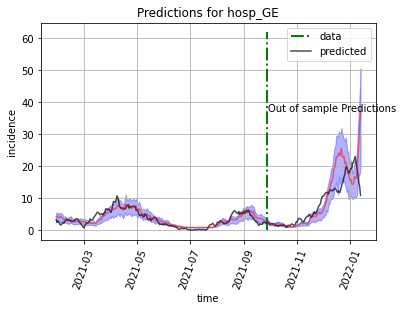

In [25]:
indice = list(df.index)
indice = [i.date() for i in indice]
    
plot_predicted_vs_data(
        predicted,
        np.concatenate((Y_train, Y_test), axis=0),
        indice[:],
        label="{}".format('hosp_GE'),
        pred_window=14,
        factor=factor,
        split_point=len(Y_train),
        uncertainty= False
    )